TODO
- Graph labels / titles

In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [229]:
%load_ext autoreload
%autoreload 2

from utils import scatter_with_outliers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Client

In [230]:
clients = pd.read_csv("clients.csv")
clients.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


# Data type verifications

In [231]:
# duplicates
clients.duplicated().sum()

0

In [232]:
# check if client_id is a primary key (SQL)
clients["client_id"].duplicated().sum()

0

There are no duplicate values and the "client_id" is a primary key because it has no duplicates / missing values. The clients are uniques

In [233]:
clients.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


The "sex" variable seems to be a qualitative binary variable, let's check :

In [234]:
clients["sex"].unique()

array(['f', 'm'], dtype=object)

The "birth" variable seem to be a temporal variable, let's convert it : 

In [235]:
clients["birth"] = pd.to_datetime(clients["birth"], format="%Y")

# Product

In [236]:
products = pd.read_csv("produits.csv")
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


# Data type verifications

In [237]:
# duplicated verification
products.duplicated().sum()

0

In [238]:
# check if "id_prod" is a primary key
products["id_prod"].duplicated().sum()

0

There are no duplicate values and the "product_id" is a primary key because it has no duplicates / missing values. The products are uniques

In [239]:
products.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


The "price" variable has a value range of -1 to 300 (min / max) but -1 is not possible for a price. We will have to correct this when we correct the outliers

The "categ" variable looks like a qualitative variable, let's check it :

In [240]:
products["categ"].unique()

array([0, 1, 2])

The "categ" variable is a qualitative variable and we think it  is a nominal variable

# Sales

In [241]:
sales = pd.read_csv("ventes.csv")
sales.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


# Data type verification

In [242]:
# duplicated verification
sales.duplicated().sum()

126

In [243]:
# drop duplicates
sales = sales.drop_duplicates()
print(f"Number of sales after drop duplicates: {len(sales)}")

Number of sales after drop duplicates: 336890


For the sales we don't have clearly defined primary key but we can create one from date and client_id. We decided to take the cliend_id because two transactions may have been made at the same time. Check :

In [244]:
# without client_id
sales["date"].duplicated().sum()

35

In [245]:
# with client_id
sales[["client_id", "date"]].duplicated().sum()

0

In [246]:
def compare_keys(col, df1, df2):
  df1_keys = pd.DataFrame(df1[col].unique())
  df2_keys = pd.DataFrame(df2[col].unique())

  keys_1 = df1_keys.merge(df2_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']
  print("df1 not in df2", len(keys_1))

  keys_2 = df2_keys.merge(df1_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']
  print("df2 not in df1 :", len(keys_2))

compare_keys(col="client_id", df1=clients, df2=sales)
compare_keys(col="id_prod", df1=products, df2=sales)

df1 not in df2 0
df2 not in df1 : 21
df1 not in df2 1
df2 not in df1 : 22


In each key that the **sales** table references, there are fewer unique values than in the other 2 tables: 
- 21 registred clients did not place an order
- 22 products not sold

In [247]:
# "id_prod" only present in sales
sales[~sales["id_prod"].isin(products["id_prod"])]

,id_prod,date,session_id,client_id
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580
...,...,...,...,...
322710,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167
329417,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790
330490,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189
335531,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595


There is one product present only in transactions: 0_2245 (103 occurrences)

In [248]:
sales.describe(include="all")

,id_prod,date,session_id,client_id
count,336890,336890,336890,336890
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237443,s_0,c_1609
freq,1081,2,74,12855


There are fewer unique session identifiers than dates, so a single session can contain multiple transaction dates 

# Merge datas

In [249]:
merged = sales.merge(clients, how="left", on="client_id")
merged = merged.merge(products, how="left", on="id_prod")
merged

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977-01-01,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979-01-01,10.71,1.0
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963-01-01,4.20,0.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980-01-01,8.99,0.0
...,...,...,...,...,...,...,...,...
336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969-01-01,31.99,1.0
336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991-01-01,22.99,0.0
336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968-01-01,11.03,0.0
336888,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,f,1994-01-01,50.99,2.0


In [250]:
# check duplicated
merged[["client_id", "date"]].duplicated().sum()

0

# Cleaning

Deletion of the lines where the date is invalid :

In [251]:
row_with_invalid_date = merged[pd.to_datetime(merged["date"], errors="coerce").isnull()].index
merged = merged.drop(row_with_invalid_date).reset_index()
print("Drop", len(row_with_invalid_date), "rows")

Drop 74 rows


Now we can convert the "date" to a datetime type :

In [252]:
merged["date"] = pd.to_datetime(merged["date"])
merged.head()

,index,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977-01-01,4.99,0.0
1,1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0
2,2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979-01-01,10.71,1.0
3,3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963-01-01,4.20,0.0
4,4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980-01-01,8.99,0.0


Now lets check the value who have a "price" equal to -1

In [253]:
merged[merged["price"] == -1]

,index,id_prod,date,session_id,client_id,sex,birth,price,categ


We no longer have row where the price value is equal -1.  Let's visualize our datas :

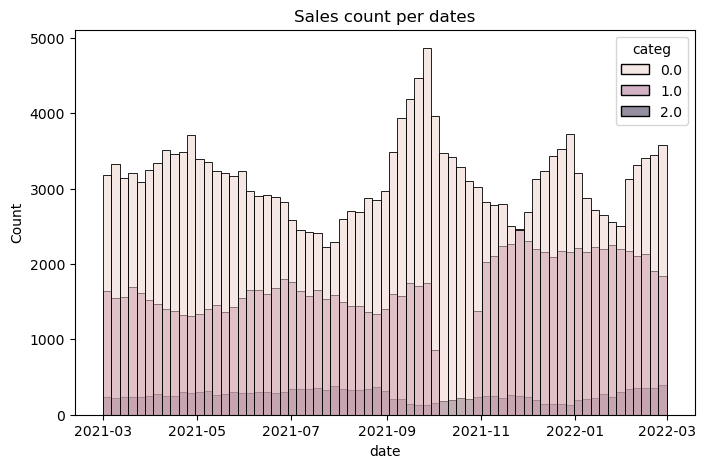

In [254]:
plt.figure(figsize=(8, 5))
sns.histplot(data=merged, x="date", hue="categ")
plt.title("Sales count per dates")
plt.show()

We can see that there are missing data between 2021-09 and 2021-11 for values in categ 1. Let's see it :

In [255]:
october_categ_1 = merged[((merged["date"] >= "2021-09") & (merged["date"] <= "2021-12")) & (merged["categ"] == 1)]
october_categ_1["date"].sort_values().dt.strftime("%Y-%m-%d").unique()

array(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
       '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
       '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
       '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
       '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
       '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
       '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
       '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-28',
       '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01',
       '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
       '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09',
       '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13',
       '2021-11-14', '2021-11-15', '2021-11-16', '2021-11-17',
       '2021-11-18', '2021-11-19', '2021-11-20', '2021-11-21',
       '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-25',
       '2021-11-26', '2021-11-27', '2021-11-28', '2021-

We can see that it misses practically the whole october month. Instead add random values we decide to cut all datas in this period :

In [256]:
october_condition = ((merged["date"] >= "2021-10-01") & (merged["date"] <= "2021-10-31"))
len_before_deletion = len(merged)
merged = merged.drop(merged[october_condition].index)
print(len_before_deletion - len(merged), "rows deleted")

20646 rows deleted


In [257]:
# We don't need this anymore
del october_categ_1
del october_condition
del len_before_deletion

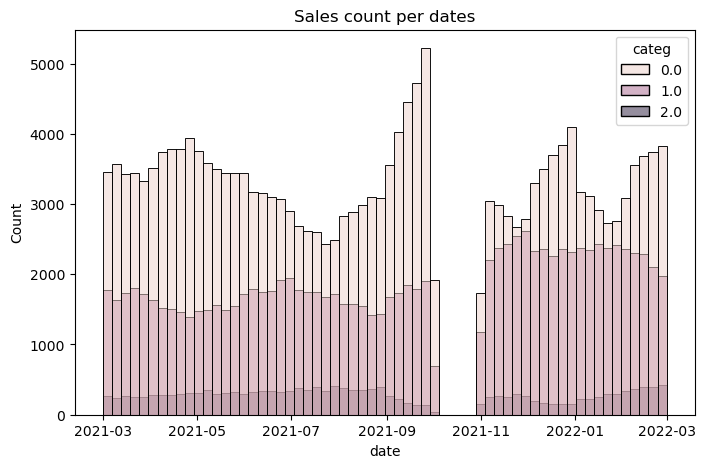

In [258]:
# Let's visualize our data now
plt.figure(figsize=(8, 5))
sns.histplot(data=merged, x="date", hue="categ")
plt.title("Sales count per dates")
plt.show()

We still have the problem of missing prices and categories :

In [259]:
merged.isnull().sum(), merged["price"].isnull().sum() / len(merged) * 100

(index          0
 id_prod        0
 date           0
 session_id     0
 client_id      0
 sex            0
 birth          0
 price         96
 categ         96
 dtype: int64,
 0.03036341208843344)

Missing values represente 0.03 percent of our dataset. We can delete it :

In [263]:
merged = merged.drop(merged[merged["price"].isnull()].index)
merged

,index,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977-01-01,4.99,0.0
1,1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0
2,2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979-01-01,10.71,1.0
4,4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980-01-01,8.99,0.0
5,5,0_1085,2021-09-15 05:47:48.215162,s_90139,c_2526,f,1982-01-01,3.99,0.0
...,...,...,...,...,...,...,...,...,...
336810,336884,1_498,2022-02-03 01:39:15.793010,s_159138,c_1857,f,1990-01-01,23.37,1.0
336811,336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969-01-01,31.99,1.0
336812,336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991-01-01,22.99,0.0
336813,336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968-01-01,11.03,0.0


In [54]:
merged = sales.join(products.add_prefix("product_"), how="inner", on="id_prod", validate="m:1")
merged = merged.join(clients, how="inner", on="client_id", validate="m:1")
# merged = merged.convert_dtypes() # optimisation
merged

,id_prod,date,session_id,client_id,product_price,product_categ,sex,birth
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977
157663,0_1085,2021-09-29 11:14:59.793823,s_97382,c_4450,3.99,0,f,1977
122466,0_1453,2021-08-27 19:50:46.796939,s_81509,c_4450,7.99,0,f,1977
183267,0_1405,2021-08-27 20:07:25.878440,s_81509,c_4450,4.99,0,f,1977
205592,0_1392,2021-12-28 11:45:04.072281,s_141302,c_4450,6.30,0,f,1977
...,...,...,...,...,...,...,...,...
242464,1_607,2021-09-25 07:26:00.224331,s_95185,c_4786,26.99,1,f,1967
26001,1_673,2021-06-01 00:49:49.781631,s_42350,c_2793,12.99,1,m,1933
302259,0_2075,2021-10-09 09:03:48.268536,s_102200,c_2793,8.99,0,m,1933
298145,0_1692,2021-09-15 19:42:08.596375,s_90430,c_4478,13.36,0,f,1970


## Outliers cleaning

In [38]:
from scipy.stats import zscore

## Zscore

In [101]:
merged["zscore"] = merged["product_price"].pipe(zscore)
zscore_outliers = merged[merged["zscore"].abs() > 2]
zscore_outliers

,id_prod,date,session_id,client_id,product_price,product_categ,sex,birth,zscore
276465,2_141,2021-06-10 22:40:08.751037,s_46907,c_1576,158.99,2,m,1956,7.940667
122291,1_10,2021-08-22 14:45:30.620297,s_79219,c_1609,78.83,1,m,1980,3.451327
125942,1_10,2021-04-28 21:30:47.290104,s_27146,c_1609,78.83,1,m,1980,3.451327
148277,1_10,2021-12-03 13:20:56.948621,s_128808,c_1609,78.83,1,m,1980,3.451327
125194,1_331,2022-02-26 04:32:28.862147,s_171002,c_1609,55.99,1,m,1980,2.172179
...,...,...,...,...,...,...,...,...,...
145290,2_149,2021-07-28 08:31:44.408250,s_68148,c_5230,80.99,2,m,1997,3.572297
52795,2_223,2022-02-04 19:39:45.311376,s_159989,c_5230,175.99,2,m,1997,8.892748
251119,2_205,2021-03-11 00:11:32.016264,s_4605,c_7534,100.99,2,m,1992,4.692392
9131,2_147,2021-07-23 07:01:38.963669,s_65994,c_4391,181.99,2,f,2001,9.228776


## Interquartile

In [161]:
# TODO function
q1, q3 = np.percentile(merged["product_price"], [25, 75])
iqr = q3 - q1

lower_range = q1 - (1.5 * iqr) # TODO why 1.5
upper_range = q3 + (1.5 * iqr) # TODO why 1.5

lower_range, upper_range

(-7.034999999999998, 34.605)

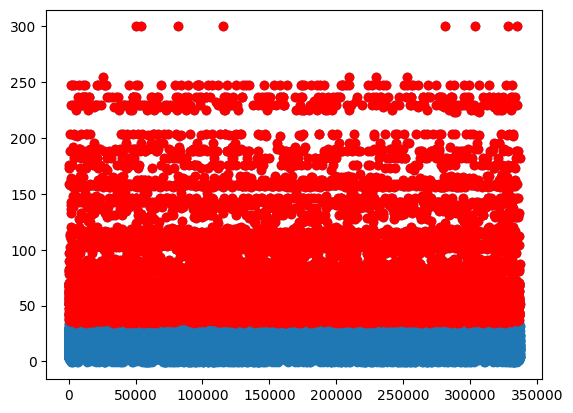

In [160]:
interquartile_outliers = merged[(merged["product_price"] < lower_range) | (merged["product_price"] > upper_range)]
scatter_with_outliers(x=merged.index,
                      y=merged["product_price"],
                      outliers_x=interquartile_outliers.index,
                      outliers_y=interquartile_outliers["product_price"])

# Scatter plot with the eye

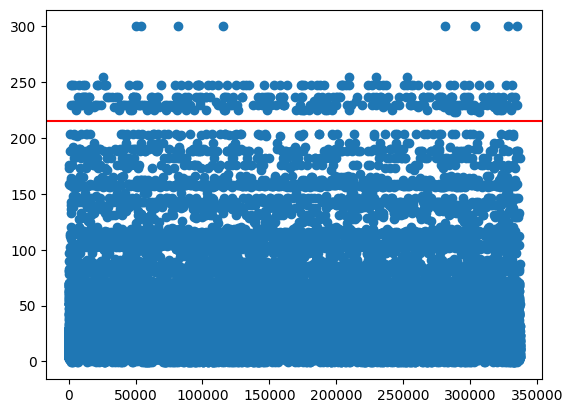

In [157]:
scatter_with_outliers(x=merged.index, y=merged["product_price"], outliers_y=215, type="htresh")

## Scatter plot (clustering)

In [117]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [135]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(merged[["product_price"]])
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=10e-4)
clustering_outliers = merged.iloc[np.where(model.fit_predict(data) == -1)]

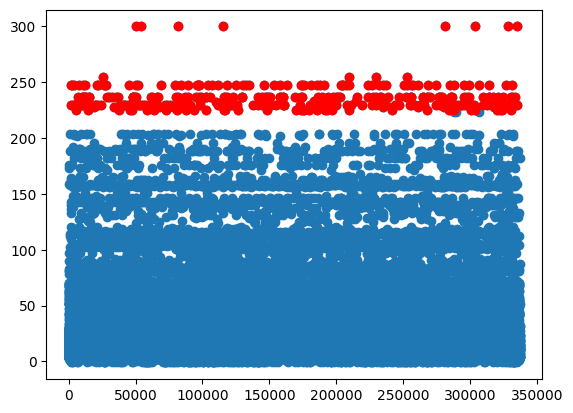

In [159]:
scatter_with_outliers(
  x=merged.index,
  y=merged["product_price"],
  outliers_x=clustering_outliers.index,
  outliers_y=clustering_outliers["product_price"]
)

## Boxplot

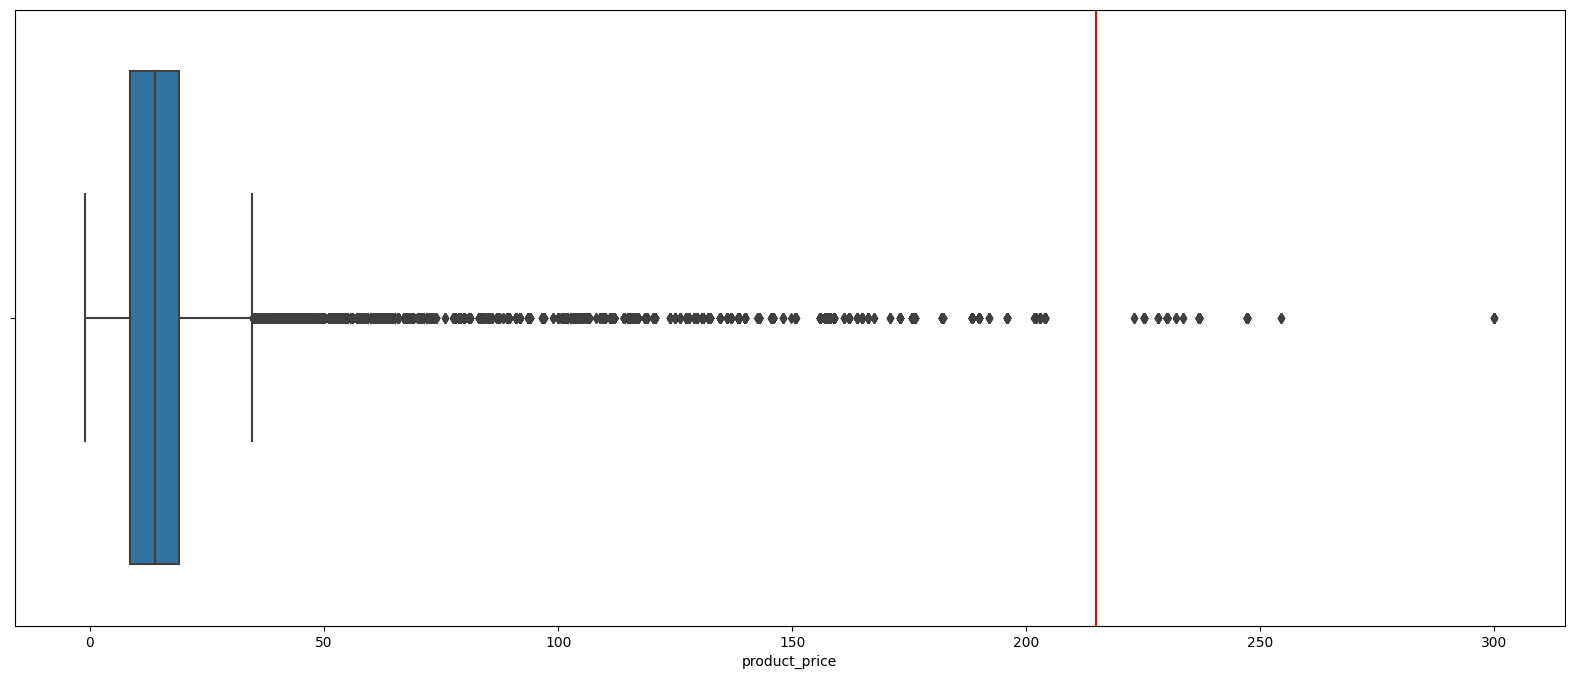

In [149]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=merged["product_price"])
plt.axvline(215, c="r")
plt.show()